In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_excel('Input/Traffic_Dummy.xlsb', engine='pyxlsb')

df.shape

(16674, 30)

In [4]:
df.dtypes

System              object
Type                object
Link                object
Link Vice Versa     object
COUNTIF              int64
LEN                  int64
ResourceName+IP     object
ResourceName        object
Towerid NE          object
IPAddress NE       float64
FE ResourceName     object
Towerid FE          object
IPAddress FE       float64
Week                 int64
Region              object
Kabupaten           object
Province            object
D1                 float64
D2                 float64
D3                 float64
D4                 float64
D5                 float64
D6                 float64
D7                 float64
MaxUtil            float64
TXUtilization      float64
Bandwidth(Kbps)    float64
TotalHit             int64
Category            object
IP address          object
dtype: object

In [5]:
df.isnull().sum()

System                 0
Type                   0
Link                   0
Link Vice Versa        0
COUNTIF                0
LEN                    0
ResourceName+IP        0
ResourceName           0
Towerid NE             0
IPAddress NE       16674
FE ResourceName        0
Towerid FE             0
IPAddress FE       16674
Week                   0
Region                 0
Kabupaten              0
Province               0
D1                   344
D2                   367
D3                   370
D4                   313
D5                   337
D6                   318
D7                   270
MaxUtil                0
TXUtilization         14
Bandwidth(Kbps)      771
TotalHit               0
Category               0
IP address             0
dtype: int64

In [6]:
# Selected Column with Least Null

df_master = df[['Type','Link','Towerid NE','Towerid FE','LEN','COUNTIF','ResourceName','D1','D2','D3','D4','D5','D6','D7','MaxUtil','TXUtilization', 'Bandwidth(Kbps)', 'TotalHit', 'Category']]
df_master.isnull().sum()


Type                 0
Link                 0
Towerid NE           0
Towerid FE           0
LEN                  0
COUNTIF              0
ResourceName         0
D1                 344
D2                 367
D3                 370
D4                 313
D5                 337
D6                 318
D7                 270
MaxUtil              0
TXUtilization       14
Bandwidth(Kbps)    771
TotalHit             0
Category             0
dtype: int64

In [7]:
# Filling Missing Value 
df_master['D1'].interpolate(method='linear', inplace=True)
df_master['D2'].interpolate(method='linear', inplace=True)
df_master['D3'].interpolate(method='linear', inplace=True)
df_master['D4'].interpolate(method='linear', inplace=True)
df_master['D5'].interpolate(method='linear', inplace=True)
df_master['D6'].interpolate(method='linear', inplace=True)
df_master['D7'].interpolate(method='linear', inplace=True)

df_master['TXUtilization'] = df_master['TXUtilization'].fillna(df_master['TXUtilization'].median())
df_master['Bandwidth(Kbps)'] = df_master['Bandwidth(Kbps)'].fillna(df_master['Bandwidth(Kbps)'].median())

df_master.isnull().sum()


Type               0
Link               0
Towerid NE         0
Towerid FE         0
LEN                0
COUNTIF            0
ResourceName       0
D1                 0
D2                 0
D3                 0
D4                 0
D5                 0
D6                 0
D7                 0
MaxUtil            0
TXUtilization      0
Bandwidth(Kbps)    0
TotalHit           0
Category           0
dtype: int64

In [8]:
lb = LabelEncoder()

# Get Column non Numerical
cat_cols = [col for col in df_master.columns if df_master[col].dtype == 'object']

for col in cat_cols:
    df_master[col] = lb.fit_transform(df_master[col])

df_master.dtypes

Type                 int32
Link                 int32
Towerid NE           int32
Towerid FE           int32
LEN                  int64
COUNTIF              int64
ResourceName         int32
D1                 float64
D2                 float64
D3                 float64
D4                 float64
D5                 float64
D6                 float64
D7                 float64
MaxUtil            float64
TXUtilization      float64
Bandwidth(Kbps)    float64
TotalHit             int64
Category             int32
dtype: object

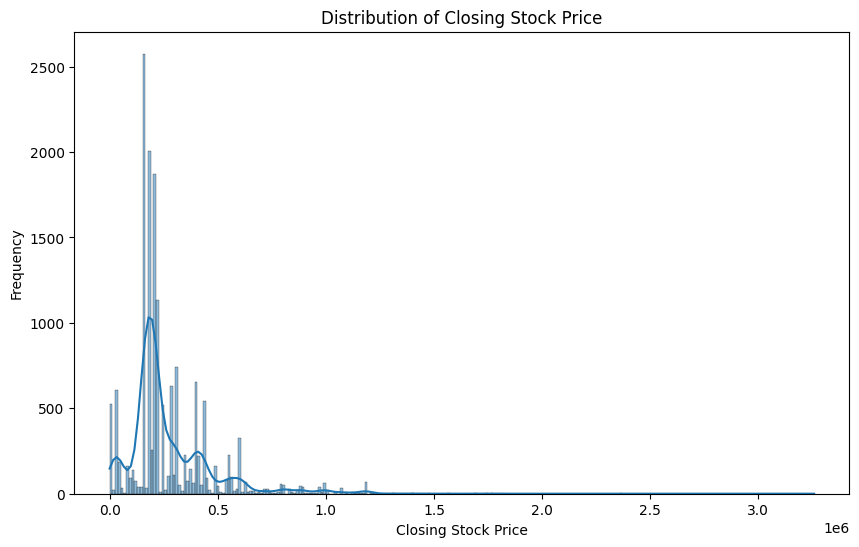

In [9]:
#  Hist Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Bandwidth(Kbps)'], kde=True)
plt.title('Distribution of Closing Stock Price')
plt.xlabel('Closing Stock Price')
plt.ylabel('Frequency')
plt.show()

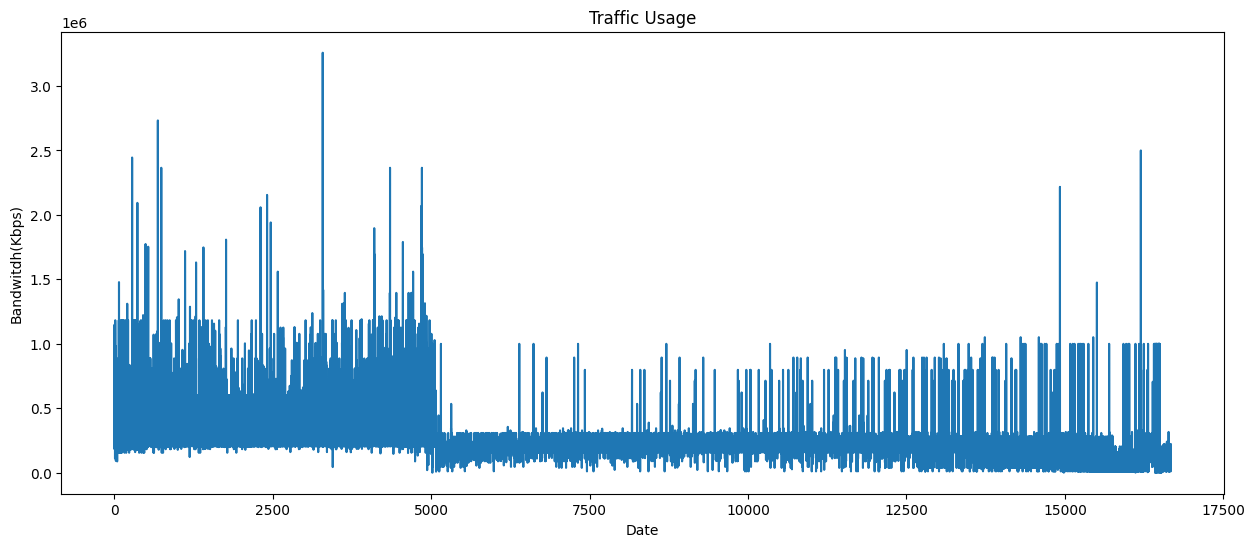

In [10]:
plt.figure(figsize=(15,6))
plt.title("Traffic Usage")
plt.plot(df_master['Bandwidth(Kbps)'])
plt.xlabel('Date')
plt.ylabel("Bandwitdh(Kbps)")
plt.show()

In [11]:
import math 

close_data = df_master.filter(['Bandwidth(Kbps)'])
dataset = close_data.values
training_data_len = math.ceil(len(dataset) * .8)

In [12]:
from sklearn.preprocessing import MinMaxScaler

#Scale Data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data[1:5]

array([[0.17449793],
       [0.06284101],
       [0.06284101],
       [0.21897949]])

In [13]:
import tensorflow as tf
from keras.layers import Dense, LSTM
from keras.models import Sequential

In [14]:
#Create Scaled Training set
train_data_scaled = scaled_data[0:training_data_len , :]

#create x_train, y_train
x_train,y_train = [],[]

for i in range(60, len(train_data_scaled)):
    x_train.append(train_data_scaled[i-60:i, 0])
    y_train.append(train_data_scaled[i, 0])

In [15]:
#Convert to array
x_train,y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(13280, 60, 1)

In [16]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('MeanSquaredError') >= 0.002):
      self.model.stop_training = True
      print("\n Accuracy Reached")

callbacks = myCallback()

In [17]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(60, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy','MeanSquaredError', 'MeanAbsoluteError'])
model.fit(x_train, y_train, batch_size=1, epochs=100, callbacks=[callbacks])

Epoch 1/100
13279/13280 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - MeanAbsoluteError: 0.0338 - MeanSquaredError: 0.0030 - accuracy: 1.0858e-04 - loss: 0.0030
 Accuracy Reached
13280/13280 ━━━━━━━━━━━━━━━━━━━━ 235s 17ms/step - MeanAbsoluteError: 0.0338 - MeanSquaredError: 0.0030 - accuracy: 1.0858e-04 - loss: 0.0030


In [18]:
#Create Scaled Train Set
test_data_scaled = scaled_data[training_data_len-60: , :]

#Create x_test dan y_test
x_test, y_test = [], dataset[training_data_len:, :]

for i in range(60,len(test_data_scaled)):
    x_test.append(test_data_scaled[i-60:i, 0])

In [19]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(3334, 60, 1)

In [20]:
# Get Predicted Value 
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

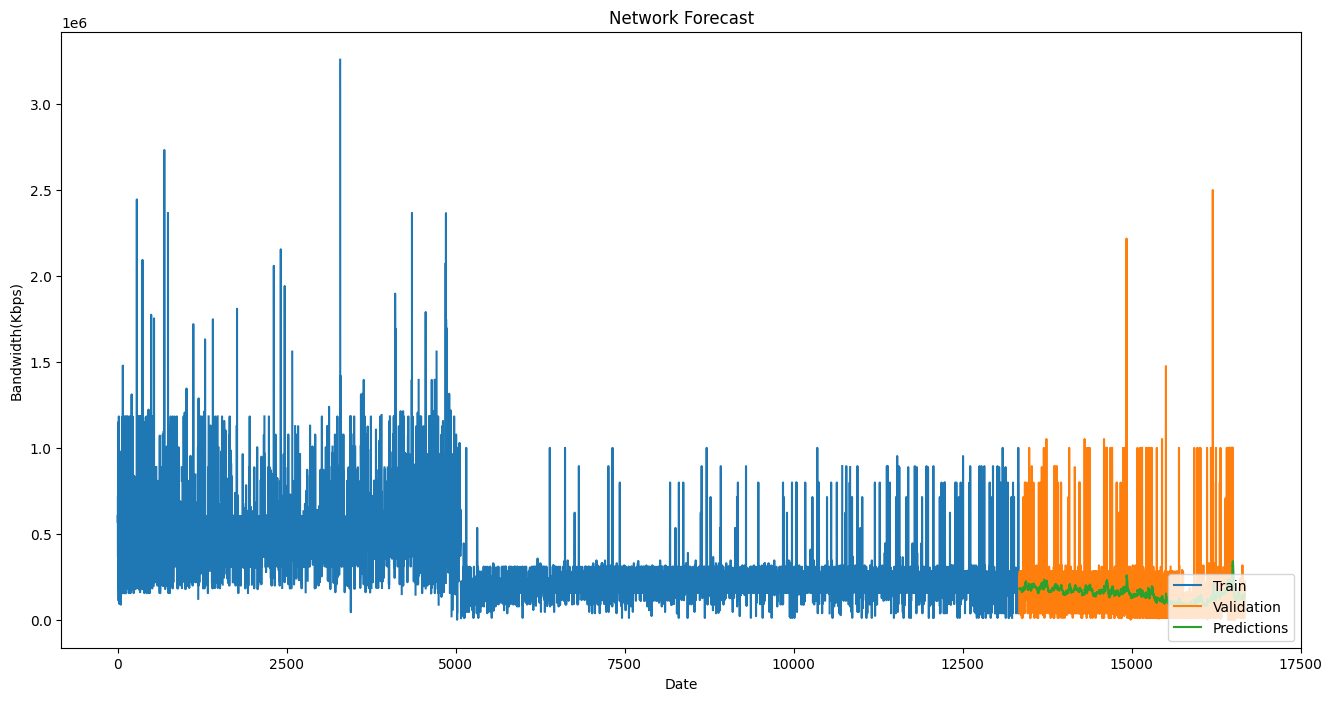

In [21]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predict

#Plot
plt.figure(figsize=(16,8))
plt.title('Network Forecast')
plt.xlabel('Date')
plt.ylabel('Bandwidth(Kbps)')
plt.plot(train["Bandwidth(Kbps)"])
plt.plot(valid[["Bandwidth(Kbps)",'Predictions']])
plt.legend(['Train','Validation','Predictions'], loc='lower right')
plt.show 

In [22]:
model.save('Output Model/Traffic Analysis/lstm_model.h5')